In [1]:
from __future__ import print_function
import numpy as np
from skimage import io
from skimage import transform
import matplotlib.pyplot as plt
import os
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms
from torchvision.utils import make_grid
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim  
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import argparse

In [2]:
root = "./"
def default_loader(path):
    return Image.open(path).convert('RGB')

In [3]:
class MyDataset(torch.utils.data.Dataset): 
    def __init__(self,root, datatxt, transform=None, target_transform=None,loader=default_loader):
        super(MyDataset,self).__init__()
        fh = open(root + datatxt, 'r') 
        imgs = []     
        data = []
        label = []
        for line in fh:                
            line = line.rstrip()       
            data.append(line)
        for line in range(len(data)-1):
            words = data[line].split()  
            imgs.append((words[0])) 
            label.append(int(words[1]))
            
        
        self.imgs = imgs
        self.transform = transform
        self.target_transform = target_transform
        self.label = torch.LongTensor(label)
 
    # def __getitem__(self, index):    
    def __getitem__(self, idx):    
        image = Image.open(str(self.imgs[idx]))
        # image = image.convert('RGB')
        image = image.convert('L')
        if self.transform is not None:
            image = self.transform(image)
        label = self.label[idx]
        return image, label
    def __len__(self): 
        return len(self.imgs)

In [4]:
train_dataset = MyDataset(root='./',datatxt='train.txt',transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ]))
test_dataset = MyDataset(root='./',datatxt='test.txt', transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ]))
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True,num_workers=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=True,num_workers=1)
print('num_of_trainData:', len(train_dataset))
print('num_of_testData:', len(test_dataset))

num_of_trainData: 7930
num_of_testData: 1958


label： tensor(0) shape: (1, 19, 19)


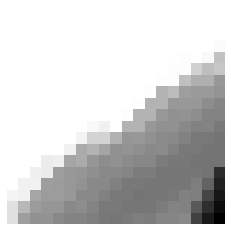

In [8]:
idx = 2
img = train_dataset[idx][0].numpy()
plt.imshow(img[0], cmap = 'gray')
plt.axis('off') 
print('label：',train_dataset[idx][1], 'shape:', img.shape)
plt.show()

In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        # self.fc1 = nn.Linear(9216, 128)
        self.fc1 = nn.Linear(3136, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output


def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            if args.dry_run:
                break


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


def main():
    # Training settings
    parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
    parser.add_argument('--batch-size', type=int, default=64, metavar='N',
                        help='input batch size for training (default: 64)')
    parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                        help='input batch size for testing (default: 1000)')
    parser.add_argument('--epochs', type=int, default=3, metavar='N',
                        help='number of epochs to train (default: 14)')
    parser.add_argument('--lr', type=float, default=1.0, metavar='LR',
                        help='learning rate (default: 1.0)')
    parser.add_argument('--gamma', type=float, default=0.7, metavar='M',
                        help='Learning rate step gamma (default: 0.7)')
    parser.add_argument('--no-cuda', action='store_true', default=False,
                        help='disables CUDA training')
    parser.add_argument('--dry-run', action='store_true', default=False,
                        help='quickly check a single pass')
    parser.add_argument('--seed', type=int, default=1, metavar='S',
                        help='random seed (default: 1)')
    parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                        help='how many batches to wait before logging training status')
    parser.add_argument('--save-model', action='store_true', default=False,
                        help='For Saving the current Model')
    args, unknown = parser.parse_known_args()
    use_cuda = not args.no_cuda and torch.cuda.is_available()

    torch.manual_seed(args.seed)

    device = torch.device("cuda" if use_cuda else "cpu")

    kwargs = {'batch_size': args.batch_size}
    if use_cuda:
        kwargs.update({'num_workers': 1,
                       'pin_memory': True,
                       'shuffle': True},
                     )

    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])

    model = Net().to(device)
    optimizer = optim.Adadelta(model.parameters(), lr=args.lr)

    scheduler = StepLR(optimizer, step_size=1, gamma=args.gamma)
    for epoch in range(1, args.epochs + 1):
        train(args, model, device, train_loader, optimizer, epoch)
        test(model, device, test_loader)
        scheduler.step()

    if args.save_model:
        torch.save(model.state_dict(), "mnist_cnn.pt")


if __name__ == '__main__':
    main()

Train Epoch: 1 [0/7930 (0%)]	Loss: 0.702040
Train Epoch: 1 [640/7930 (8%)]	Loss: 0.622679
Train Epoch: 1 [1280/7930 (16%)]	Loss: 0.570558
Train Epoch: 1 [1920/7930 (24%)]	Loss: 0.586467
Train Epoch: 1 [2560/7930 (32%)]	Loss: 0.613969
Train Epoch: 1 [3200/7930 (40%)]	Loss: 0.469223
Train Epoch: 1 [3840/7930 (48%)]	Loss: 0.477362
Train Epoch: 1 [4480/7930 (56%)]	Loss: 0.307548
Train Epoch: 1 [5120/7930 (65%)]	Loss: 0.529348
Train Epoch: 1 [5760/7930 (73%)]	Loss: 0.376486
Train Epoch: 1 [6400/7930 (81%)]	Loss: 0.402503
Train Epoch: 1 [7040/7930 (89%)]	Loss: 0.447611
Train Epoch: 1 [7680/7930 (97%)]	Loss: 0.298414

Test set: Average loss: 0.3069, Accuracy: 1716/1958 (88%)

Train Epoch: 2 [0/7930 (0%)]	Loss: 0.292274
Train Epoch: 2 [640/7930 (8%)]	Loss: 0.264161
Train Epoch: 2 [1280/7930 (16%)]	Loss: 0.244519
Train Epoch: 2 [1920/7930 (24%)]	Loss: 0.286745
Train Epoch: 2 [2560/7930 (32%)]	Loss: 0.352754
Train Epoch: 2 [3200/7930 (40%)]	Loss: 0.387613
Train Epoch: 2 [3840/7930 (48%)]	Loss: 0

In [15]:
class GaborConv(nn.Module):
    def __init__(self, kernel_size, in_channels, num_orientations, num_scales):
        super(GaborConv, self).__init__()
        self.sigma1, self.theta1, self.Lambda1, self.psi1, self.gamma1, self.bias1 = self.generate_parameters(num_orientations*num_scales, in_channels)
        self.sigma2, self.theta2, self.Lambda2, self.psi2, self.gamma2, self.bias2 = self.generate_parameters(num_orientations*num_scales, in_channels)
        # self.filter1 = self.whole_filter(in_channels, channel1, kernel_size, self.sigma1, self.theta1, self.Lambda1, self.psi1, self.gamma1)
        self.filter_cos = self.whole_filter(in_channels, num_orientations, num_scales, kernel_size, self.sigma1, self.theta1, self.Lambda1, self.psi1, self.gamma1, True)
        self.filter_sin = self.whole_filter(in_channels, num_orientations, num_scales, kernel_size, self.sigma1, self.theta1, self.Lambda1, self.psi1, self.gamma1, False)

#         self.conv = nn.Conv2d(48, 50, 5, 1)
        
        self.fc1 = nn.Linear(1*1*48, 24)
        self.fc2 = nn.Linear(24, 2)


    def forward(self, x):
        x_cos = F.conv2d(x, self.filter_cos, bias=self.bias1)
        x_sin = F.conv2d(x, self.filter_sin, bias=self.bias2)
        x_comb = torch.cat((x_cos, x_sin), 1)
#         x_comb = F.max_pool2d(x_comb, 2, 2)
#         x_comb = F.relu(self.conv(x_comb))
#         x_comb = F.max_pool2d(x_comb, 2, 2)

        x_comb = x_comb.view(-1, 1*1*48)
        x_comb = F.relu(self.fc1(x_comb))
        x_comb = self.fc2(x_comb)
        return F.log_softmax(x_comb, dim=1)


    def generate_parameters(self, dim_out, dim_in):
        sigma = nn.Parameter(torch.randn(1, 1))
        theta = nn.Parameter(torch.randn(1, 1))
        Lambda = nn.Parameter(torch.randn(1, 1))
        psi = nn.Parameter(torch.randn(1, 1))
        gamma = nn.Parameter(torch.randn(1, 1))
        bias = nn.Parameter(torch.randn(dim_out))
        return sigma, theta, Lambda, psi, gamma, bias


    def whole_filter(self, in_channels, num_orientations, num_scales, kernel_size, sigma, theta, Lambda, psi, gamma, cos):
        result = torch.zeros(num_orientations*num_scales, in_channels, kernel_size, kernel_size) # \text{out\_channels} , \frac{\text{in\_channels}}{\text{groups}} , kH , kW
        for k in range(num_orientations*num_scales):
            for i in range(num_orientations):
                for j in range(num_scales):
                    result[k] = self.one_filter(in_channels, kernel_size, sigma[0]*(2.1**j), theta[0]+i*2*np.pi/num_orientations, Lambda[0], psi[0], gamma[0], cos)
        return nn.Parameter(result)


    def one_filter(self, in_channels, kernel_size, sigma, theta, Lambda, psi, gamma, cos):
        result = torch.zeros(in_channels, kernel_size, kernel_size)
        for i in range(in_channels):
            result[i] = self.gabor_fn(sigma, theta, Lambda, psi, gamma, kernel_size, cos)
        return nn.Parameter(result)


    def gabor_fn(self, sigma, theta, Lambda, psi, gamma, kernel_size, cos):
        sigma_x = sigma
        # sigma_y = float(sigma) / gamma
        sigma_y = sigma / gamma

        # Bounding box
        half_size = (kernel_size - 1) // 2
        ymin, xmin = -half_size, -half_size
        ymax, xmax = half_size, half_size
        (y, x) = np.meshgrid(np.arange(ymin, ymax + 1), np.arange(xmin, xmax + 1))
        y = torch.FloatTensor(y)
        x = torch.FloatTensor(x)

        # Rotation
        x_theta = x * torch.cos(theta) + y * torch.sin(theta)
        y_theta = -x * torch.sin(theta) + y * torch.cos(theta)

        if cos:
            gb = torch.exp(-.5 * (x_theta ** 2 / sigma_x ** 2 + y_theta ** 2 / sigma_y ** 2)) * torch.cos(2 * np.pi / Lambda * x_theta + psi)
        else:
            gb = torch.exp(-.5 * (x_theta ** 2 / sigma_x ** 2 + y_theta ** 2 / sigma_y ** 2)) * torch.sin(2 * np.pi / Lambda * x_theta + psi)
        return gb


In [16]:
def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward(retain_graph=True)
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(args, model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

def main():
    # Training settings
    parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
    parser.add_argument('--batch-size', type=int, default=64, metavar='N',
                        help='input batch size for training (default: 64)')
    parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                        help='input batch size for testing (default: 1000)')
    parser.add_argument('--epochs', type=int, default=3, metavar='N',
                        help='number of epochs to train (default: 10)')
    parser.add_argument('--lr', type=float, default=0.01, metavar='LR',
                        help='learning rate (default: 0.01)')
    parser.add_argument('--momentum', type=float, default=0.5, metavar='M',
                        help='SGD momentum (default: 0.5)')
    parser.add_argument('--no-cuda', action='store_true', default=False,
                        help='disables CUDA training')
    parser.add_argument('--seed', type=int, default=1, metavar='S',
                        help='random seed (default: 1)')
    parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                        help='how many batches to wait before logging training status')
    parser.add_argument('--save-model', action='store_true', default=False,
                        help='For Saving the current Model')
    parser.add_argument('--std', type=float, default=0, metavar='STD',
                        help='noise-std (default: 0)')
    parser.add_argument('--mean', type=float, default=0, metavar='MEAN',
                        help='noise-std (default: 0)')
#     args = parser.parse_args()
    args, unknown = parser.parse_known_args()
    use_cuda = not args.no_cuda and torch.cuda.is_available()

    torch.manual_seed(args.seed)

    device = torch.device("cuda" if use_cuda else "cpu")

    kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
#     train_loader = torch.utils.data.DataLoader(
#         datasets.MNIST('../data', train=True, download=True,
#                        transform=transforms.Compose([
#                            transforms.ToTensor(),
#                            transforms.Normalize((0.1307,), (0.3081,)),
#                            transforms.RandomApply([AddGaussianNoise(args.mean, args.std)], p=0.5)
#                        ])),
#         batch_size=args.batch_size, shuffle=True, **kwargs)
#     test_loader = torch.utils.data.DataLoader(
#         datasets.MNIST('../data', train=False, transform=transforms.Compose([
#                            transforms.ToTensor(),
#                            transforms.Normalize((0.1307,), (0.3081,))
#                        ])),
#         batch_size=args.test_batch_size, shuffle=True, **kwargs)

    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])
    model = GaborConv(19, 1, 6, 4).to(device)
    # if torch.cuda.is_available():
    #     torch.set_default_tensor_type('torch.cuda.FloatTensor')
    optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)

    for param in model.parameters():
        print(type(param.data), param.size())

    for epoch in range(1, args.epochs + 1):
        train(args, model, device, train_loader, optimizer, epoch)
        test(args, model, device, test_loader)
        # for param in model.parameters():
        #     print(param.size(), param.data)
        # print(model.state_dict())

    if (args.save_model):
        torch.save(model.state_dict(),"pretrain_gabor.pt")

if __name__ == '__main__':
    main()


<class 'torch.Tensor'> torch.Size([1, 1])
<class 'torch.Tensor'> torch.Size([1, 1])
<class 'torch.Tensor'> torch.Size([1, 1])
<class 'torch.Tensor'> torch.Size([1, 1])
<class 'torch.Tensor'> torch.Size([1, 1])
<class 'torch.Tensor'> torch.Size([24])
<class 'torch.Tensor'> torch.Size([1, 1])
<class 'torch.Tensor'> torch.Size([1, 1])
<class 'torch.Tensor'> torch.Size([1, 1])
<class 'torch.Tensor'> torch.Size([1, 1])
<class 'torch.Tensor'> torch.Size([1, 1])
<class 'torch.Tensor'> torch.Size([24])
<class 'torch.Tensor'> torch.Size([24, 1, 19, 19])
<class 'torch.Tensor'> torch.Size([24, 1, 19, 19])
<class 'torch.Tensor'> torch.Size([24, 48])
<class 'torch.Tensor'> torch.Size([24])
<class 'torch.Tensor'> torch.Size([2, 24])
<class 'torch.Tensor'> torch.Size([2])
Train Epoch: 1 [0/7930 (0%)]	Loss: 0.679505
Train Epoch: 1 [640/7930 (8%)]	Loss: 0.540476
Train Epoch: 1 [1280/7930 (16%)]	Loss: 0.550538
Train Epoch: 1 [1920/7930 (24%)]	Loss: 0.470420
Train Epoch: 1 [2560/7930 (32%)]	Loss: 0.52675